# Higher-order models

## Step Test

Using a Temperature Control Lab device initially at steady state at ambient room temperature, the following device settings were used to induce a step response in $T_1$ and $T_2$.  

| P1 | P1 | U1 | U2 |
| :--: | :--: | :--: | :--: |
| 200 | 100 | 50 | 0 |

Data was recorded for 800 seconds and saved to a .csv data file. Some noise and data dropouts are evident in the data. The data file is accessible at the link given in the code cell below. 

The challenge is to develop a first-principles models that reproduces the system measured response shown below.

<AxesSubplot:xlabel='Time', ylabel='%'>

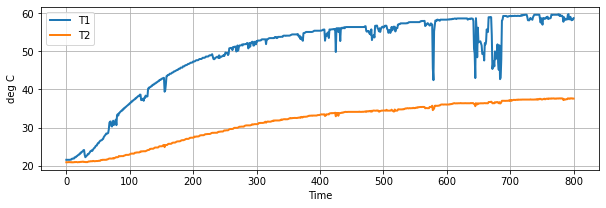

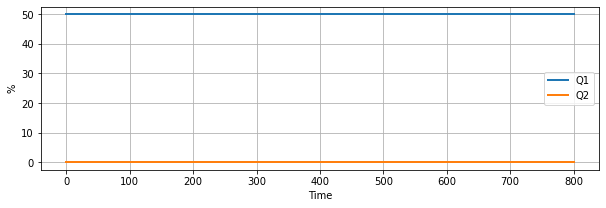

In [23]:
import pandas as pd

data_file = "https://raw.githubusercontent.com/jckantor/cbe30338-book/main/notebooks/data/tclab-data-example.csv"
data = pd.read_csv(data_file)
data.plot(x = "Time", y=["T1", "T2"], figsize=(10, 3), grid=True, lw=2, ylabel="deg C")
data.plot(x = "Time", y=["Q1", "Q2"], figsize=(10, 3), grid=True, lw=2, ylabel="%")


## Two-State Model

### Dynamics of the Heater/Sensor System

For this model we no longer assume  the heater and sensor are at the same temperature. To account for differing temperatures, we introduce $T_{H,1}$ to denote the temperature of heater one and $T_{S,1}$ to denote the temperature of the corresponding sensor. We further assume the sensor exchanges heat only with the heater, and heat transfer to the surroundings is dominated by the heat sink attached to the heater.

This motivates a model

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}

where $C^H_p$ and $C^S_p$ are the heat capacities of the heater and sensor, respectively, and $U_b$ is a new heat transfer coefficient characterizing the exchange of heat between the heater and sensor.

\begin{align}
\frac{dT_{H,1}}{dt} & = -\frac{U_a+U_b}{C^H_p}T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1}) 
\end{align}

Where measured temperature, that is, the temperature recorded by the Arduino, $T_1$ is given by

$$T_1 = T_{S,1}$$

<AxesSubplot:>

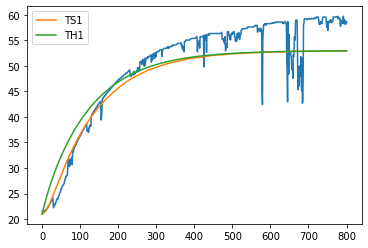

In [45]:
import numpy as np
from scipy.integrate import solve_ivp
import  pandas as pd

# known parameters
T_amb = 21             # deg C
alpha = 0.00016        # watts / (units P1 * percent U1)
P1 = 200               # P1 units
U1 = 50                # steady state value of u1 (percent)

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C

# extract data from experiment
t_expt = df["Time"]

def tclab_model2(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub = param

    # model solution
    def deriv(t, y):
        T1H, T1S = y
        dT1H = (-(Ua + Ub)*T1H + Ub*T1S + alpha*P1*U1 + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        return [dT1H, dT1S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb, T_amb], t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["Time"])
    pred["TH1"] = soln.y[0]
    pred["TS1"] = soln.y[1]
    pred["Q1"] = U1
        
    return pred
    
pred = tclab_model2([CpH, CpS, Ua, Ub], plot=True)

ax = data["T1"].plot()
pred[["TS1", "TH1"]].plot(ax=ax)

### "Least Squares" Model Fitting

Fitting a model to data is a basic task in engineering, science, business, and a foundation of modern data sciences. For engineers the goal is to validate hypotheses about how a device works, then to enable simulation and design. In the data science model fitting may be almost completely empirical using black box models to develop predictive models of complex systems.

In this case we wish to find values for a small number of parameters that cause a model to replicate a measured response. One common measure of fit is the sum of sum of squares of residual difference between the model and data. For residuals modeled as independent and identically distributed random variables from a Gaussian distribution, minimizing the sum of squares has a strong theoretical foundation. So strong, in fact, the term "least squares" has become synonomous with model fitting and regression.

:::{admonition} Why is model fitting called "regression"?

Someone will have to explain to me why the word "regession" is use to the describe the task of fitting a model to data. After all, the textbook definition of regression is to return to a less advanced state, and the verb "to regress" has distinct negative connotations. Seems odd, doesn't it?

:::

The SciPy library includes a well-developed function [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) for this purpose. The name is a misnomoer because the function allows other common "loss" functions in addition to sum of squares. The simplest use of `least_squares` is to provide a function that, given values for the unknown parameters, creates a vector of residuals between a model and data. 

This is demonstrated below.

CpH = 4.9671247633757565,  CpS = 0.7581362862029133,   Ua = 0.0437340380938552,  Ub = 0.02134718248191959


<AxesSubplot:>

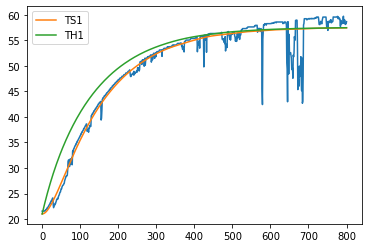

In [50]:
from scipy.optimize import least_squares

def fun(p):
    pred = tclab_model2(p)
    return pred["TS1"] - data["T1"]

results = least_squares(fun,  [CpH, CpS, Ua, Ub])

CpH, CpS, Ua, Ub = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub}")

pred = tclab_model2(results.x)

ax = data["T1"].plot()
pred[["TS1", "TH1"]].plot(ax=ax)

<AxesSubplot:>

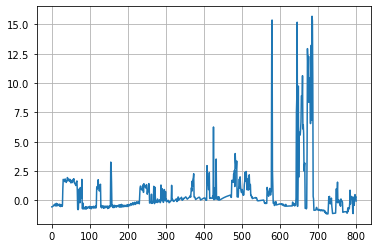

In [48]:
(pred["TS1"] - data["T1"]).plot(grid=True)

:::{admonition} Loss Functions

Consult the documentation page [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Modify the regression to use alternative loss functions including `soft_l1`, `huber`, `cauchy` and `arctan`. 

1. Which gives the best result? 
2. From the documentation, why is the fit better? 
3. How much of difference does it make it estimated model parameters?

:::

## Fourth-Order Multi-Input Multi-Output Model

### Model derivation

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + U_c(T_{H,2}-T_{H,1})  + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1})  \\
C^H_p\frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{S,2} - T_{H,2}) + U_c(T_{H,1}-T_{H,2}) + \alpha P_2 u_2\\
C^S_p\frac{dT_{S,2}}{dt} & = U_b(T_{H,2} - T_{S,2}) 
\end{align}

where

\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}

### Standard form

\begin{align}
\frac{dT_{H,1}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{U_c}{C^H_p}T_{H,2}  + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1})  \\
\frac{dT_{H,2}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,2} + \frac{U_b}{C^H_p}T_{S,2} + \frac{U_c}{C^H_p}T_{H,1}  + \frac{\alpha P_2}{C^H_p}u_2 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,2}}{dt} & = \frac{U_b}{C^S_p}(T_{H,2} - T_{S,2}) 
\end{align}

where

\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}

<AxesSubplot:>

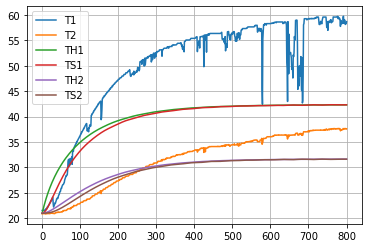

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C
Uc = 0.05              # watts/deg C

P2 = 100
U2 = 0

def tclab_model4(param):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  

    # model solution
    def deriv(t, y):
        T1H, T1S, T2H, T2S= y
        dT1H = (-(Ua + Ub + Uc)*T1H + Ub*T1S + Uc*T2H + alpha*P1*U1 + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        dT2H = (-(Ua + Ub + Uc)*T2H + Ub*T2S + Uc*T1H + alpha*P2*U2 + Ua*T_amb)/CpH
        dT2S = Ub*(T2H - T2S)/CpS
        return [dT1H, dT1S, dT2H, dT2S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(t_expt, columns=["Time"])
    pred["TH1"] = soln.y[0]
    pred["TS1"] = soln.y[1]
    pred["TH2"] = soln.y[2]
    pred["TS2"] = soln.y[3]
    
    return pred
    
pred = tclab_model4([CpH, CpS, Ua, Ub, Uc])

ax = data[["T1", "T2"]].plot()
pred[["TH1", "TS1", "TH2", "TS2"]].plot(ax=ax, grid=True)

CpH = 5.864796918520442,  CpS = 0.0016217913175027958,   Ua = 0.0288533838667384,  Ub = 7.00888791812829e-05, Uc = 0.021725334058753258


<AxesSubplot:>

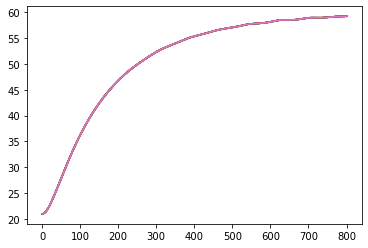

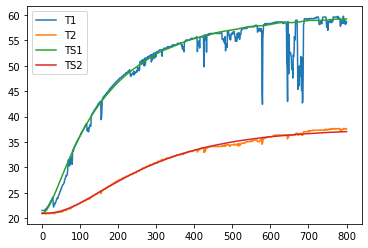

In [75]:
from scipy.optimize import least_squares

def fun(p):
    pred = tclab_model4(p)
    pred["TS1"].plot()
    err1 = pred["TS1"] - data["T1"]
    err2 = pred["TS2"] - data["T2"]
    
    return pd.concat([err1, err2])

results = least_squares(fun,  [CpH, CpS, Ua, Ub, Uc], loss="cauchy")

CpH, CpS, Ua, Ub, Uc = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub}, Uc = {Uc}")

pred = tclab_model4(results.x)

ax = data[["T1", "T2"]].plot()
pred[["TS1", "TS2"]].plot(ax=ax)